# Marketing and business strategy

**Objective**  
Analyze the market and optimize them strategies to attract more clients.

**Objective Sprint 2**  
What accommodation characteristics (amenities, capacity, and area rating) are most related to prices in each city?

**Description and characteristics of dataset**  
Pre-processed and cleaned dataframe with tourist accommodations listings.

### Libraries

In [31]:
# import libraries 
import os
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from dotenv import load_dotenv, find_dotenv
from download_data import get_latest_table

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

## Load environment variables

In [32]:
# load environment variables
dotenv_path = find_dotenv()
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print(".env file not found")

# environment variables because we need connect to mysql
CONFIG = {
    'user': os.getenv('MYSQL_USER'),
    'password': os.getenv('MYSQL_PASSWORD'),
    'host': os.getenv('HOST'),
    'database': 'Equip_F',
    'raise_on_warnings': True
}

### Connection to MySQL

In [33]:
import mysql.connector
from mysql.connector import Error

try:
    # Establish connection to MySQL
    connection = mysql.connector.connect(**CONFIG)
    
    if connection.is_connected():
        db_info = connection.get_server_info()
        print(f"Conexión exitosa a MySQL Server versión {db_info}")
        cursor = connection.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print(f"Conectado a la base de datos: {record[0]}")

except Error as e:
    print(f"Error al conectar a MySQL: {e}")

Conexión exitosa a MySQL Server versión 8.0.41-0ubuntu0.24.04.1
Conectado a la base de datos: Equip_F


## Overview data

In [34]:
#df_new = pd.read_sql("""SELECT * FROM ST1_Tourist_Accommodation""", connection)
#df_new.shape


## Business Question 2
### What accommodation characteristics (amenities, capacity, and area rating) are most related to prices in each city?

In [35]:
df = pd.read_sql("""SELECT * FROM ST1_Tourist_Accommodation""", connection)
df.shape
df.info()

C:\Users\admin\AppData\Local\Temp\ipykernel_7964\472372921.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""SELECT * FROM ST1_Tourist_Accommodation""", connection)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7693 entries, 0 to 7692
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7693 non-null   int64         
 1   name                         7690 non-null   object        
 2   description                  7643 non-null   object        
 3   host_id                      7693 non-null   int64         
 4   neighbourhood_name           7693 non-null   object        
 5   neighbourhood_district       4669 non-null   object        
 6   room_type                    7693 non-null   object        
 7   accommodates                 7693 non-null   int64         
 8   bathrooms                    7652 non-null   float64       
 9   bedrooms                     7654 non-null   float64       
 10  beds                         7685 non-null   float64       
 11  amenities_list               7677 non-null 

## Cleaning ameneties_list

In [36]:
import pandas as pd
import re

def clean_amenities(amenities_str):
    if pd.isna(amenities_str) or amenities_str == '':
        return ''

    # Remove brackets and split by comma
    amenities_list = re.sub(r'[\[\]\']', '', amenities_str).split(',')

    # Remove extra whitespace and empty strings
    cleaned_list = [amenity.strip() for amenity in amenities_list if amenity.strip()]

    # Join back into a comma separated string
    return ','.join(cleaned_list)

df['amenities_list'] = df['amenities_list'].apply(clean_amenities)

## Create table N with amenities_list

In [37]:
#create table N with amenities_list
import pandas as pd

amenities_expanded = []
for index, row in df.iterrows():
    apartment_id = row['apartment_id']
    amenities = row['amenities_list']
    if amenities:
        amenities_list = amenities.split(',')
        for i, amenity in enumerate(amenities_list):
            amenities_expanded.append([apartment_id, i + 1, amenity.strip()])

amenities_df = pd.DataFrame(amenities_expanded, columns=['apartment_id', 'id_correlativo', 'prestacion'])
amenities_df

,apartment_id,id_correlativo,prestacion
0,11964,1,TV
1,11964,2,Internet
2,11964,3,Wifi
3,11964,4,Air conditioning
4,11964,5,Elevator
...,...,...,...
167569,32423292,3,Pets allowed
167570,32423292,4,Washer
167571,32423292,5,Hangers
167572,32423292,6,Iron


## Top 20 Amenities..

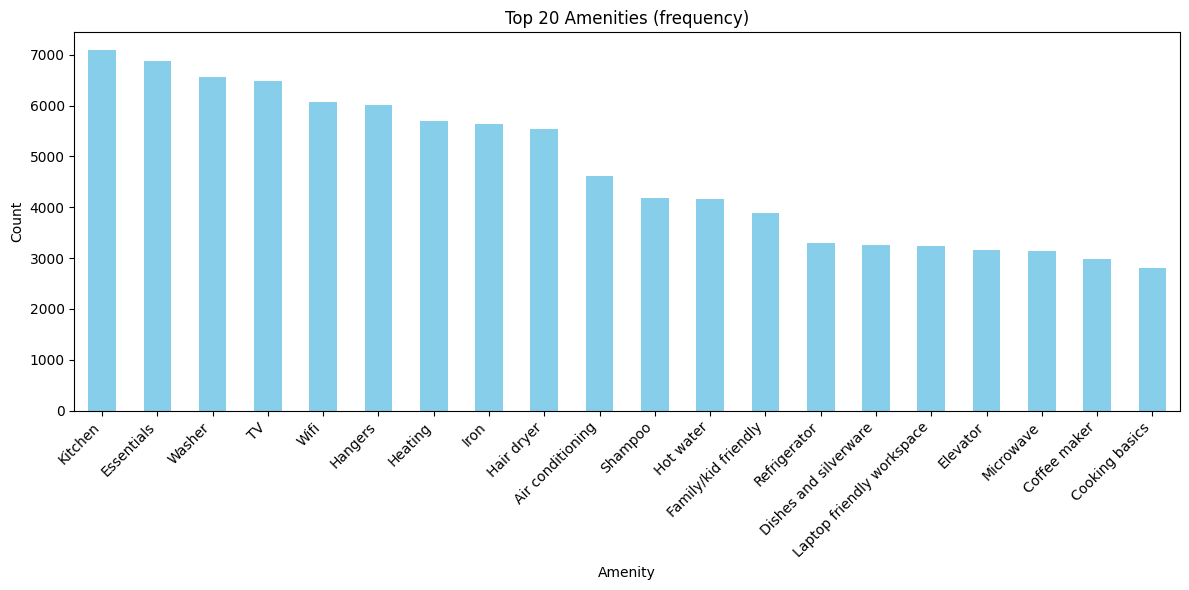

In [38]:
# Top 20 Amenities
import matplotlib.pyplot as plt

# count amenity
amenity_counts = amenities_df['prestacion'].value_counts()

# top 20 amenities
top_20_amenities = amenity_counts.head(20)

#  bar plot
plt.figure(figsize=(12, 6))
top_20_amenities.plot(kind='bar', color='skyblue')
plt.title('Top 20 Amenities (frequency)')
plt.xlabel('Amenity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## and the top 20 but with average price

        apartment_id  id_correlativo        prestacion  average_price
0              11964               1                TV    1115.307242
1              11964               2          Internet    1101.084668
2              11964               3              Wifi    1051.039132
3              11964               4  Air conditioning    1141.999133
4              11964               5          Elevator     865.462729
...              ...             ...               ...            ...
167569      32423292               3      Pets allowed    1108.308231
167570      32423292               4            Washer    1091.353776
167571      32423292               5           Hangers    1019.270764
167572      32423292               6              Iron    1094.549911
167573      32423292               7  Private entrance    1315.546176

[167574 rows x 4 columns]


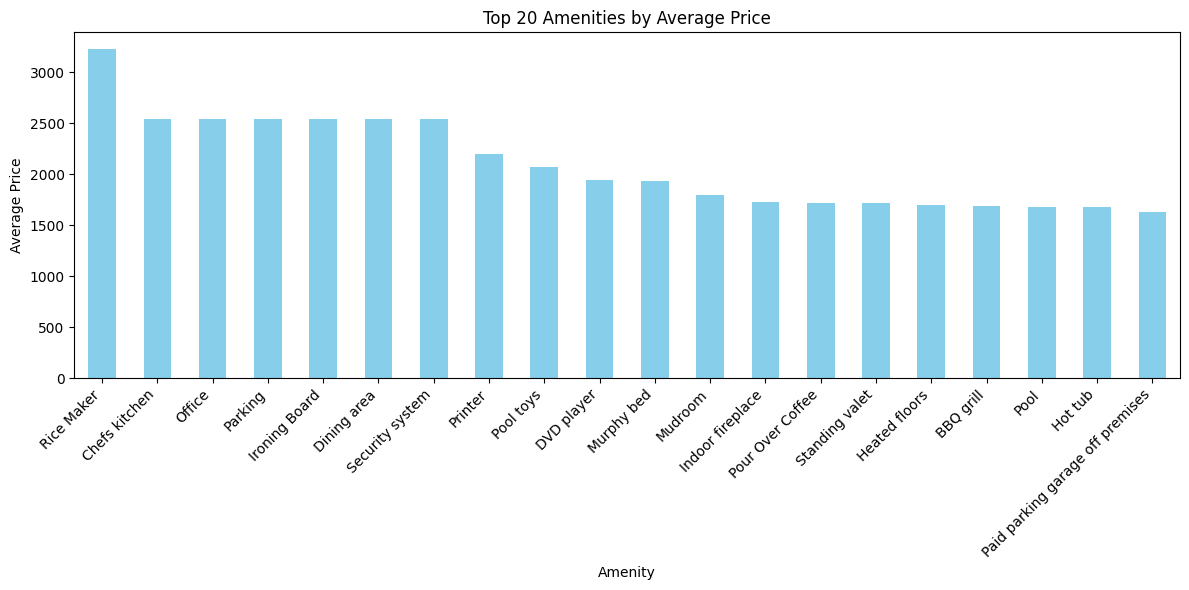

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# merge
merged_df = pd.merge(amenities_df, df[['apartment_id', 'price']], on='apartment_id', how='left')

# Calculate the average price for each amenity
average_price_by_amenity = merged_df.groupby('prestacion')['price'].mean().reset_index()
average_price_by_amenity.rename(columns={'price': 'average_price'}, inplace=True)

# Merge the average price back into the amenities dataframe
amenities_df = pd.merge(amenities_df, average_price_by_amenity, on='prestacion', how='left')

# Display the updated amenities_df
print(amenities_df)

# Now you can create the bar plot using the average price
plt.figure(figsize=(12, 6))
amenities_df.groupby('prestacion')['average_price'].mean().sort_values(ascending=False).head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Amenities by Average Price')
plt.xlabel('Amenity')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

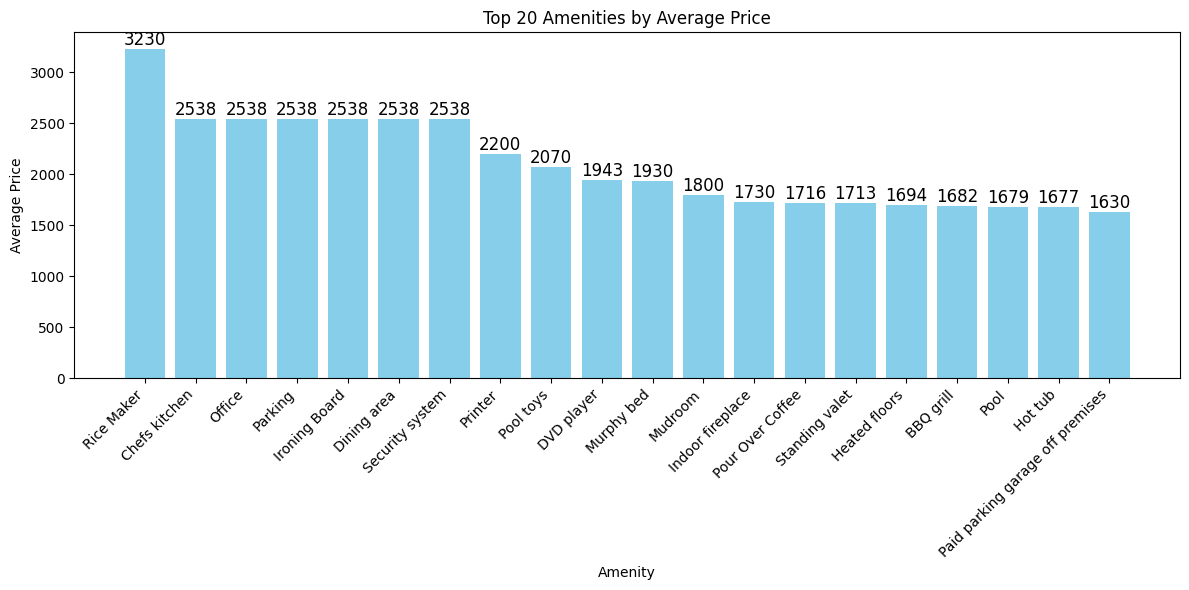

In [40]:
plt.figure(figsize=(12, 6))
average_prices = amenities_df.groupby('prestacion')['average_price'].mean().sort_values(ascending=False).head(20)
bars = plt.bar(average_prices.index, average_prices.values, color='skyblue')
plt.title('Top 20 Amenities by Average Price')
plt.xlabel('Amenity')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')

# Add the average price as a label on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Correlation matrix
### First distribution analysis

We check the distribution type. This is necessary to determine a method in a correlation matrix

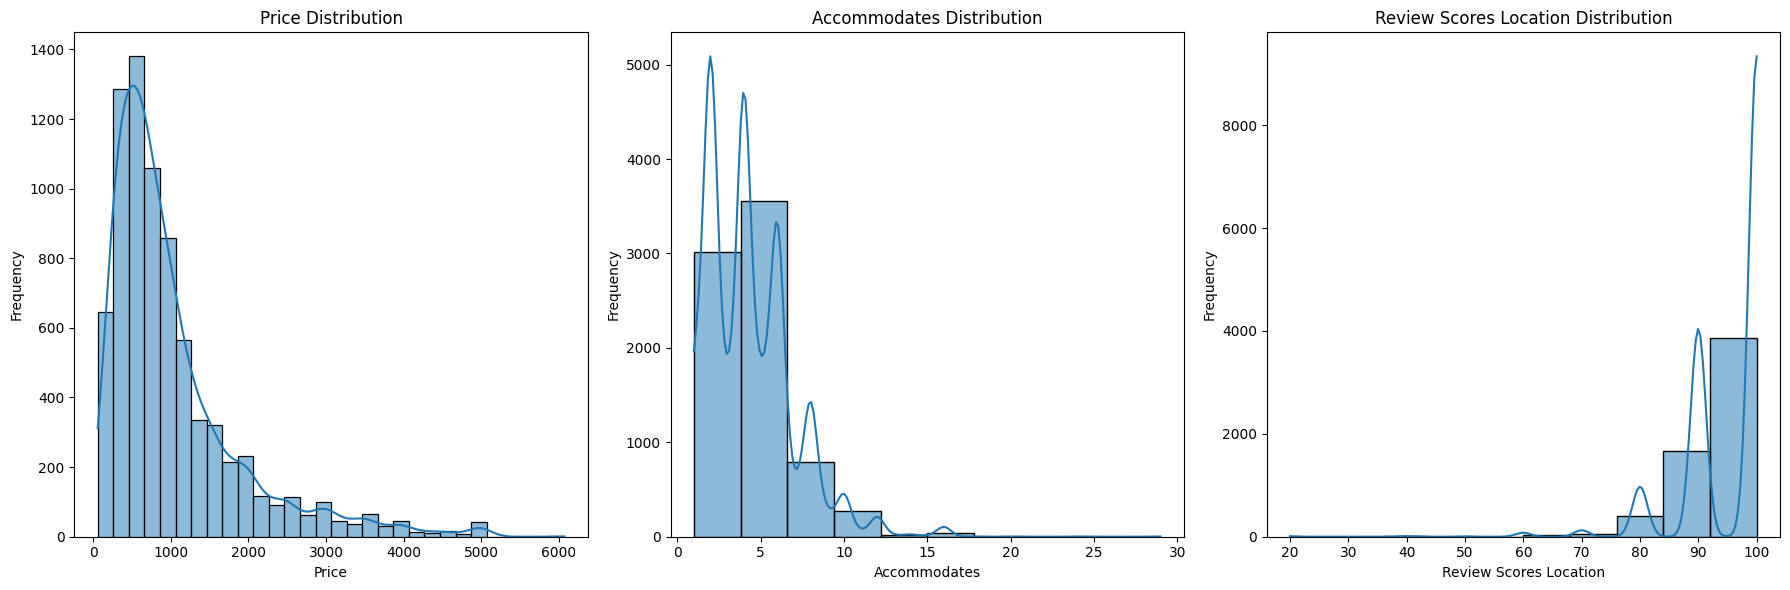

In [41]:
import matplotlib.pyplot as plt

# ## distribution

plt.figure(figsize=(18, 6))  

plt.subplot(1, 3, 1)  # Subplot for 'price'
sns.histplot(df['price'], bins=30, kde=True)  # Adjust number of bins as needed
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)  # Subplot for 'accommodates'
sns.histplot(df['accommodates'], bins=10, kde=True)  # Adjust number of bins as needed
plt.title('Accommodates Distribution')
plt.xlabel('Accommodates')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)  # Subplot for 'review_scores_location'
sns.histplot(df['review_scores_location'], bins=10, kde=True)  # Adjust number of bins as needed
plt.title('Review Scores Location Distribution')
plt.xlabel('Review Scores Location')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Correlation Matrix
First approximation, using the number of services and the intensity of the correlation with price.

The Spearman correlation matrix is ​​shown below, since the distribution, as shown above, is not normal

## Merge, Group by and count amenities

In [42]:
import pandas as pd

# merge 1 -> N
merged_df = pd.merge(df, amenities_df, on='apartment_id', how='inner')

#group by, count amenities
grouped_amenities = merged_df.groupby(['accommodates', 'review_scores_location', 'standardized_city', 'apartment_id', 'price'])['prestacion'].count().reset_index(name='amenity_count')
grouped_amenities

,accommodates,review_scores_location,standardized_city,apartment_id,price,amenity_count
0,1,40.0,Barcelona,14965707,300.0,11
1,1,60.0,Barcelona,20236173,550.0,13
2,1,60.0,Madrid,28379429,110.0,46
3,1,70.0,Barcelona,17521644,380.0,12
4,1,70.0,Barcelona,20950596,80.0,8
...,...,...,...,...,...,...
6029,16,100.0,Málaga,23588436,1880.0,28
6030,16,100.0,Málaga,25368513,150.0,10
6031,16,100.0,Palma,11162926,3860.0,21
6032,16,100.0,Palma,13792358,3048.0,22


## Correlation Matrix

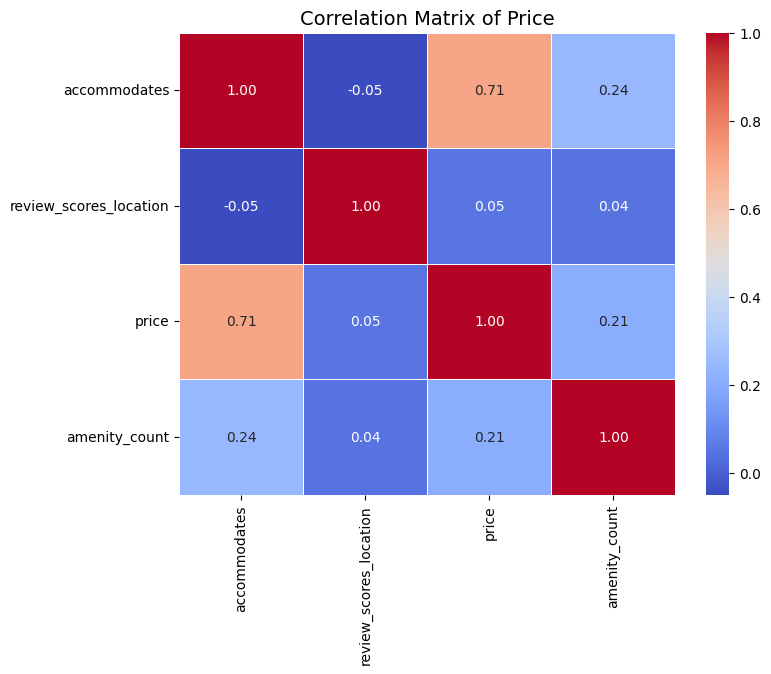

In [43]:
import pandas as pd
import numpy as np

numeric_df = grouped_amenities[['accommodates', 'review_scores_location', 'price', 'amenity_count']]

# Remove rows with missing values in selected columns
numeric_df = numeric_df.dropna()

# Convert 'price' column to numeric, handling errors
numeric_df['price'] = pd.to_numeric(numeric_df['price'], errors='coerce')
numeric_df = numeric_df.dropna(subset=['price'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr(method="spearman")

correlation_matrix

# graficar correlación en var numéricos

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 10}) # Use a more visually appealing colormap and format annotations
plt.title('Correlation Matrix of Price', fontsize=14)
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)
plt.show()

## Conclusion and Recommendations

**General Observations:**  
***Executive Business Analysis***

***Most Expensive Room Types***


***Significant Price Variations by Location***


**Recommendation:** 
